In [ ]:
import torch
from SVI_solver_library.transform.AdapterTransform import AdapterTransform as Adapter
from SVI_solver_library.solver.ProjSolver import ProjSolver as ProjSolver

In [2]:
def P_X(u, l, h):
    return torch.where(u < l, l, torch.where(u > h, h, u))

In [3]:
def P_ex(u):
    return P_X(u, torch.tensor([1, 0, 0, 1], dtype=torch.double), 100)

In [4]:
def F_ex(u):
    return torch.tensor([3*u[0] - 1/(u[0] + 0.1) + 3*u[1] - 2,
                  3*u[0] + 3 * u[1],
                  4*u[2] + 3*u[3],
                  4*u[2] + 4*u[3] - 1 / (u[3] + 0.1) - 3],dtype=torch.double)

In [ ]:
F = Adapter(F_ex)
P = Adapter(P_ex)
Ex_solver = ProjSolver(F, torch.tensor([4, 4, 4, 4], dtype=torch.double), P = P)
u_ex = torch.rand(4, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

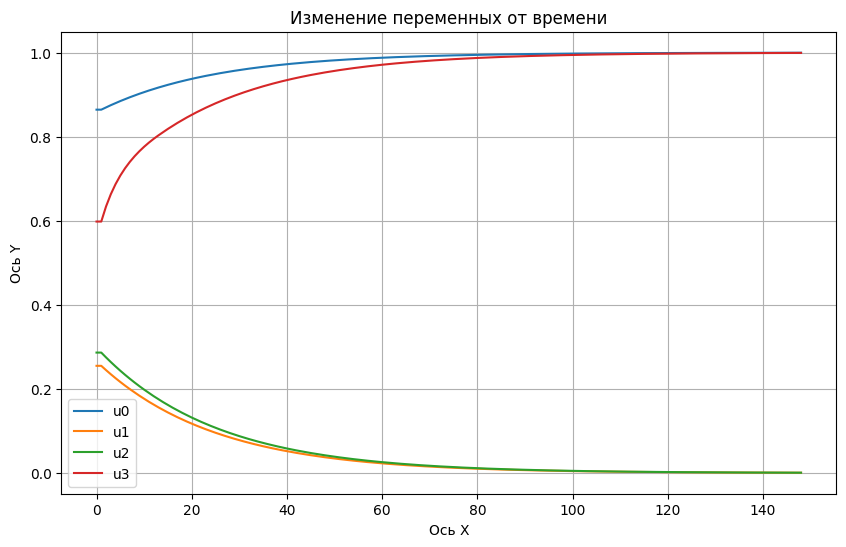

In [8]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()

In [9]:
def project(x, C):
    norm = np.linalg.norm(x)
    if norm > 1:
        return x / norm
    return x

In [10]:
def P_ex1(u):
    return project(u, 1)

In [11]:
def F_ex1(u):
    return 4*u**3 - 4*u

In [ ]:
F_1 = Adapter(F_ex1)
P_1 = Adapter(P_ex1)
Ex_solver = ProjSolver(F_1, torch.tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=torch.double), P = P_1)
u_ex = torch.rand(10, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [13]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

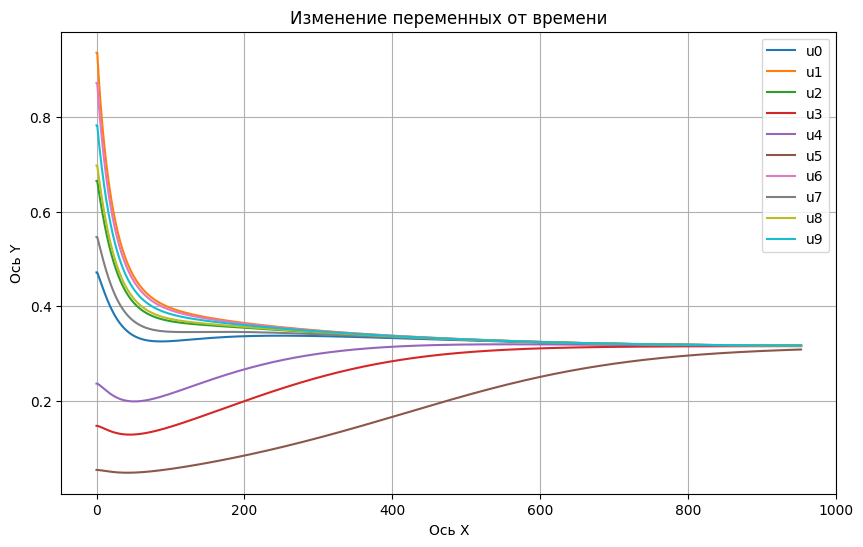

In [ ]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 
plt.plot(u4_history.numpy(), label='u4') 
plt.plot(u5_history.numpy(), label='u5') 
plt.plot(u6_history.numpy(), label='u6') 
plt.plot(u7_history.numpy(), label='u7') 
plt.plot(u8_history.numpy(), label='u8') 
plt.plot(u9_history.numpy(), label='u9') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()